In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft

expts = ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]
client = tt.startdask(nthreads=1,n_workers = 26)

client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35577 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:33043' processes=26 threads=26, memory=416.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35577/status,
Dashboard: /proxy/35577/status,Workers: 26
Total threads: 26,Total memory: 416.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33043,Workers: 26
Dashboard: /proxy/35577/status,Total threads: 26
Started: Just now,Total memory: 416.00 GiB
Comm: tcp://127.0.0.1:33355,Total threads: 1
Dashboard: /proxy/42621/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:34623,


# EF reflection plan:

Still an unresolved question! Do we 
1. Use a geometric argument to filter the incoming and reflected EF?

    Pros:
     - Easy to explain and implement

    Cons:
     - A bit subjective as to area chosen
     - Likely hard to see a clean result
2. Or do a directional filter first

    Pros:
     - Easier to compare to Klymak 2016
     - Easy to interpret

    Cons:
     - FFT too close to boundary, could get edge effects
     - Have to handle / explain cross terms

## General to do:

* Choose the surface / contour integral. Either straight lines, or follow an isobath
* Write function to take surface integral for EF input


# Load in the stuff we saved earlier!


In [ ]:
expt = "full-10"

data = {}
for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20","full-40","beamless-40","smooth-40"]:
# for expt in ["full-10","beamless-10","smooth-10","beamless-20","smooth-20","full-20"]:
    path = Path(f"/scratch/nm03/ab8992/april25/outputs") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    data[expt] = xr.merge(
    [
        xr.open_dataset(path / "EF_alongbeam.nc").rename({"EF":"EF_alongbeam"}).mean("time").load(),
        xr.open_dataset(path / "EF_acrossbeam.nc").rename({"EF":"EF_acrossbeam"}).mean("time").load(),
        xr.open_dataset(path / "EF_alongbeam_forward.nc"),
        xr.open_dataset(path / "EF_alongbeam_backward.nc"),
        xr.open_dataset(path / "EF_alongbeam_xterm.nc"),
        xr.open_dataset(path / "EF_acrossbeam_forward.nc"),
        xr.open_dataset(path / "EF_acrossbeam_backward.nc"),
        xr.open_dataset(path / "EF_acrossbeam_xterm.nc"),
        xr.open_dataset(path / "filtered_dissipation.nc"),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).sel(xb = slice(0,1200))



## Test out a basic straight line segment contour plot

Text(0.5, 0.98, 'smooth-10')

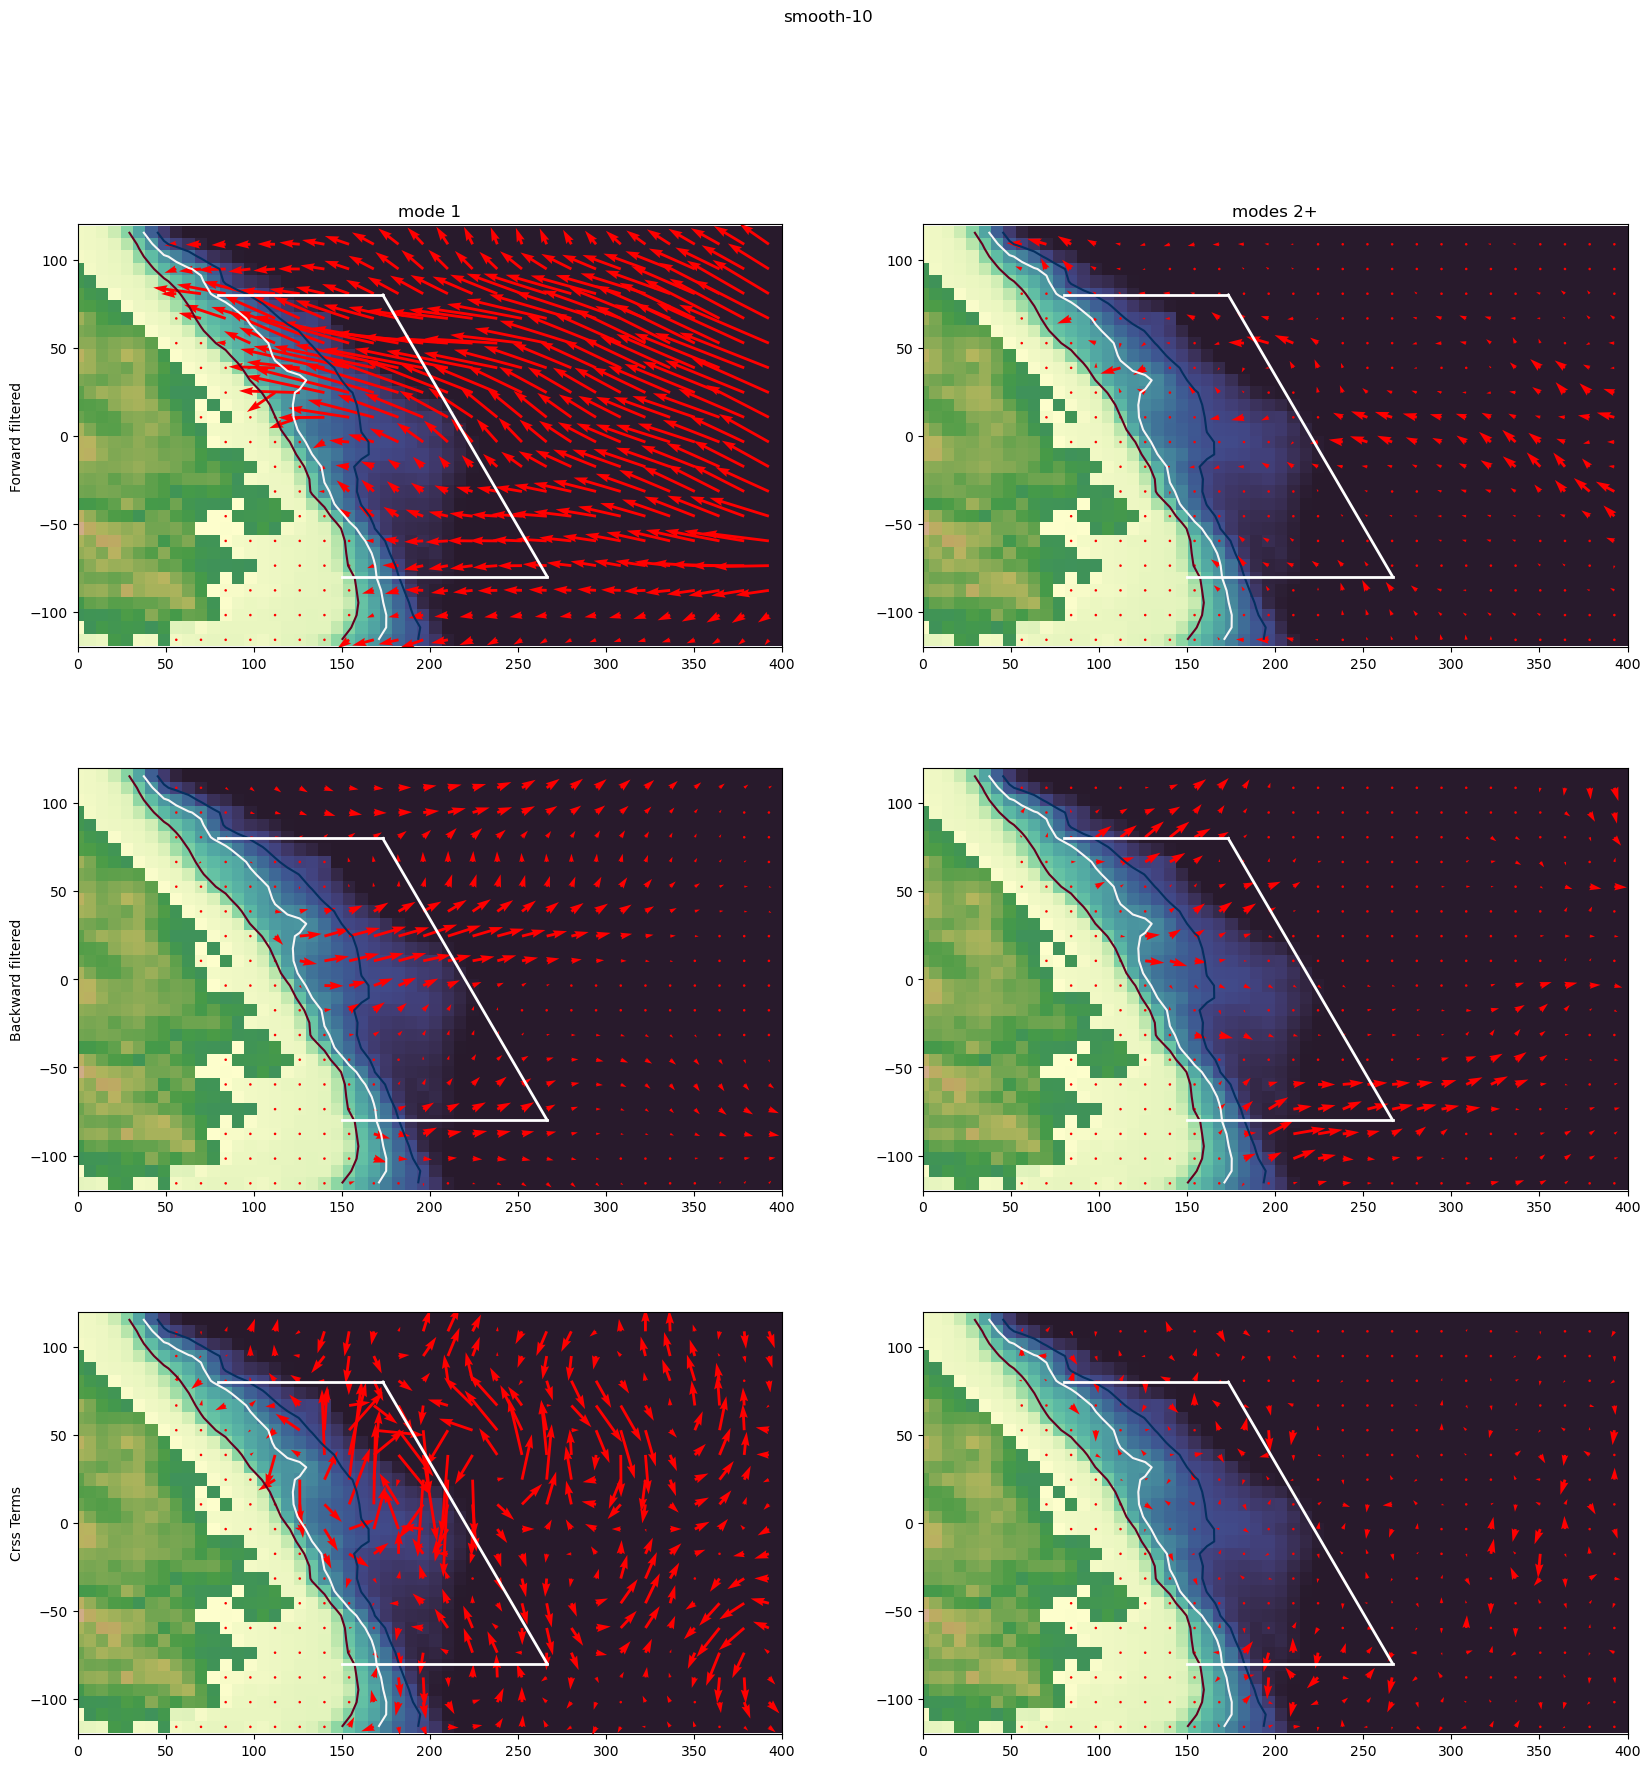

In [ ]:
## Define EF integrating, masking and plotting functions
def plot_KE_quiver(alongbeam,acrossbeam,ax,mode = 0,xlim = slice(50,250),ylim = slice(-80,80),scale = 3000):
    # expt = "full-20"
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)

    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")

    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    yspacing = 2
    xspacing = 2
    if "20" in expt:
        yspacing,xspacing = yspacing * 2, xspacing * 2
    elif "40" in expt:
        yspacing,xspacing = yspacing * 4, xspacing * 4
    _yb = acrossbeam.yb[::yspacing]
    _xb = acrossbeam.xb[::xspacing]
    _along = (alongbeam )[::yspacing,::xspacing]
    _across = (acrossbeam)[::yspacing,::xspacing]

    # print(magnitude)
    ax.quiver(_xb, _yb, _along, _across, color="red", scale=scale,scale_units = "width",width = 0.004)
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    ax.set_ylim(-120,120)
    ax.set_xlim(0,1200)
    ax.set_xlabel("")
    ax.set_ylabel("")


def mean_EF_in_box(alongbeam,acrossbeam):
    total_EF = (
        contour_integral_NS(acrossbeam) + 
        contour_integral_east(alongbeam, acrossbeam)
    )
    mean_EF = total_EF / (east_length + north_length + south_length)
    mean_EF /= 1000 # Switch W to kW
    return mean_EF

def contour_mask_east(data):
    dx = (data.xb[1] - data.xb[0]).values
    return data.where(
        (np.abs(data.yb - m * data.xb - c) < dx) *
          (np.abs(data.yb) <= ymax)
        ).fillna(0)
def contour_integral_east(alongbeam,acrossbeam):
    alongbeam = contour_mask_east(alongbeam)
    acrossbeam = contour_mask_east(acrossbeam)
    # out = alongbeam.sum("xb").integrate("yb") * (-1 * np.sin(theta)) ## Manually put in correct quadrant. i.e, positive in x direction means negative flux over contour
    # out += acrossbeam.sum("yb").integrate("xb") * (-1 * np.cos(theta))      ## Positive in y is also negative flux
    out = - alongbeam.sum("xb").integrate("yb") ## Manually put in correct quadrant. i.e, positive in x direction means negative flux over contour
    out += - acrossbeam.sum("yb").integrate("xb")      ## Positive in y is also negative flux
    return out * 1000 # Convert km -> m

def contour_integral_NS(acrossbeam):
    acrossbeam = contour_mask_NS(acrossbeam)
    out = acrossbeam.sum("yb")
    return out.integrate("xb") * 1000 # Convert km -> m

def contour_mask_NS(data):
    dx = (data.xb[1] - data.xb[0]).values
    south_mask = data.where(
        (np.abs(data.xb < (-100 - c) / m)) *
        (np.abs(data.yb + 100) < dx)
    ).fillna(0)
    north_mask = data.where(
        (np.abs(data.xb < (100 - c) / m)) *
        (np.abs(data.yb - 100) < dx)
    ).fillna(0)
    return south_mask - north_mask

## Define the Eastern angled line
x0,y0 = 150,120
x1,y1 = 290,-120
m = (y1 - y0) / (x1 - x0)
c = y0 - m * x0
theta = np.abs(np.arctan2(y1-y0,x1-x0))

## Clip the line to min and max y values
ymin, ymax = -100,100
ymin, ymax = -80,80
# ymin, ymax = -50,50
## Define Eastern angled line, calculate the length of the line in m
east_x0, east_x1 = (ymax - c) / m,(ymin - c) / m
east_y0, east_y1 = ymax,ymin
east_length = np.sqrt((east_x1 - east_x0)**2 + (east_y1 - east_y0)**2) * 1000

## Define Northern straight line, calculate the length of the line in m
north_x0,north_x1 = 80,(ymax - c) / m
north_y = ymax
north_length = np.abs(north_x1 - north_x0) * 1000

## Define Northern straight line, calculate the length of the line in m
south_x0,south_x1 = 150,(ymin - c) / m
south_y = ymin
south_length = np.abs(south_x1 - south_x0) * 1000

## Plot an example domain to show area

xmax = 400
expt = "smooth-10"
fig,ax = plt.subplots(3,2,figsize=(20,20))

for a in ax.flatten():
    data[expt].sel(xb = slice(0,xmax)).bathy.plot(vmax = 0, vmin = -4000, cmap = cmocean.cm.deep_r,ax = a,add_colorbar = False)
    data[expt].sel(xb=slice(0, xmax)).bathy.plot.contour(levels=[-1000,-2000,-3000],ax = a)

scale = 10000
plot_KE_quiver(data[expt].EF_alongbeam_forward,data[expt].EF_acrossbeam_forward,ax[0,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(data[expt].EF_alongbeam_forward,data[expt].EF_acrossbeam_forward,ax[0,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
plot_KE_quiver(data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward,ax[1,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward,ax[1,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
plot_KE_quiver(data[expt].EF_alongbeam_xterm,data[expt].EF_acrossbeam_xterm,ax[2,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(data[expt].EF_alongbeam_xterm,data[expt].EF_acrossbeam_xterm,ax[2,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
for a in ax.flatten():
    a.plot([east_x0,east_x1],[east_y0,east_y1],color = "white",linewidth = 2)
    a.plot([north_x0,north_x1],[north_y,north_y],color = "white",linewidth = 2)
    a.plot([south_x0,south_x1],[south_y,south_y],color = "white",linewidth = 2)
    a.set_aspect('equal')
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_title("")
    a.set_xlim(0,xmax)

ax[0,0].set_title("mode 1")
ax[0,1].set_title("modes 2+")
ax[0,0].set_ylabel("Forward filtered")
ax[1,0].set_ylabel("Backward filtered")
ax[2,0].set_ylabel("Crss Terms")
fig.suptitle(expt)



In [33]:

print("===  Wave energy flux onto shelf (kW/m)  ===", end="\n\n")

print("UNFILTERED")
print(f"{'Experiment':<12}{'Mode 1':>12}{'Mode 2+':>12}{'Total':>12}")

for expt in expts:
    mean_EF = mean_EF_in_box(data[expt].EF_alongbeam,data[expt].EF_acrossbeam)
    total = mean_EF.sum("mode").values
    print(f"{expt:<12}{mean_EF.isel(mode=0).values:>12.3f}{mean_EF.isel(mode=slice(1, None)).sum('mode').values:>12.3f}{total:>12.3f}")
print()
print("FORWARDS")
print(f"{'Experiment':<12}{'Mode 1':>12}{'Mode 2+':>12}{'Total':>12}")

for expt in expts:
    mean_EF = mean_EF_in_box(data[expt].EF_alongbeam_forward,data[expt].EF_acrossbeam_forward)
    total = mean_EF.sum("mode").values
    print(f"{expt:<12}{mean_EF.isel(mode=0).values:>12.3f}{mean_EF.isel(mode=slice(1, None)).sum('mode').values:>12.3f}{total:>12.3f}")

print()
print("BACKWARDS")
print(f"{'Experiment':<12}{'Mode 1':>12}{'Mode 2+':>12}{'Total':>12}")

for expt in expts:
    mean_EF = mean_EF_in_box(data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward)
    total = mean_EF.sum("mode").values
    print(f"{expt:<12}{mean_EF.isel(mode=0).values:>12.3f}{mean_EF.isel(mode=slice(1, None)).sum('mode').values:>12.3f}{total:>12.3f}")

print()
print("CROSS TERM")
print(f"{'Experiment':<12}{'Mode 1':>12}{'Mode 2+':>12}{'Total':>12}")

for expt in expts:
    mean_EF = mean_EF_in_box(data[expt].EF_alongbeam_xterm,data[expt].EF_acrossbeam_xterm)
    total = mean_EF.sum("mode").values
    print(f"{expt:<12}{mean_EF.isel(mode=0).values:>12.3f}{mean_EF.isel(mode=slice(1, None)).sum('mode').values:>12.3f}{total:>12.3f}")

print()
print("NS only")
print(f"{'Experiment':<12}{'Mode 1':>12}{'Mode 2+':>12}{'Total':>12}")


for expt in expts:
    mean_EF = mean_EF_in_box(data[expt].EF_alongbeam_forward * 0,data[expt].EF_acrossbeam)
    total = mean_EF.sum("mode").values
    print(f"{expt:<12}{mean_EF.isel(mode=0).values:>12.3f}{mean_EF.isel(mode=slice(1, None)).sum('mode').values:>12.3f}{total:>12.3f}")

===  Wave energy flux onto shelf (kW/m)  ===

UNFILTERED
Experiment        Mode 1     Mode 2+       Total
full-10            0.111       0.005       0.116
beamless-10       -0.026       0.002      -0.024
smooth-10          0.339      -0.011       0.328
beamless-20        0.001       0.001       0.003
smooth-20          1.147       0.000       1.148
full-20            0.313       0.021       0.334
full-40            0.422       0.036       0.458
beamless-40        0.102       0.017       0.119
smooth-40          1.422      -0.148       1.274

FORWARDS
Experiment        Mode 1     Mode 2+       Total
full-10            0.063       0.010       0.074
beamless-10        0.005       0.006       0.011
smooth-10          0.196       0.003       0.199
beamless-20        0.023       0.011       0.034
smooth-20          0.774       0.056       0.830
full-20            0.341       0.034       0.375
full-40            0.364       0.064       0.428
beamless-40        0.142       0.031       0.173
sm

[ 0.00866581  0.01486989 -0.02136743  0.01554762 -0.04747508 -0.04861514
  0.07394422 -0.00829149 -0.04219931]


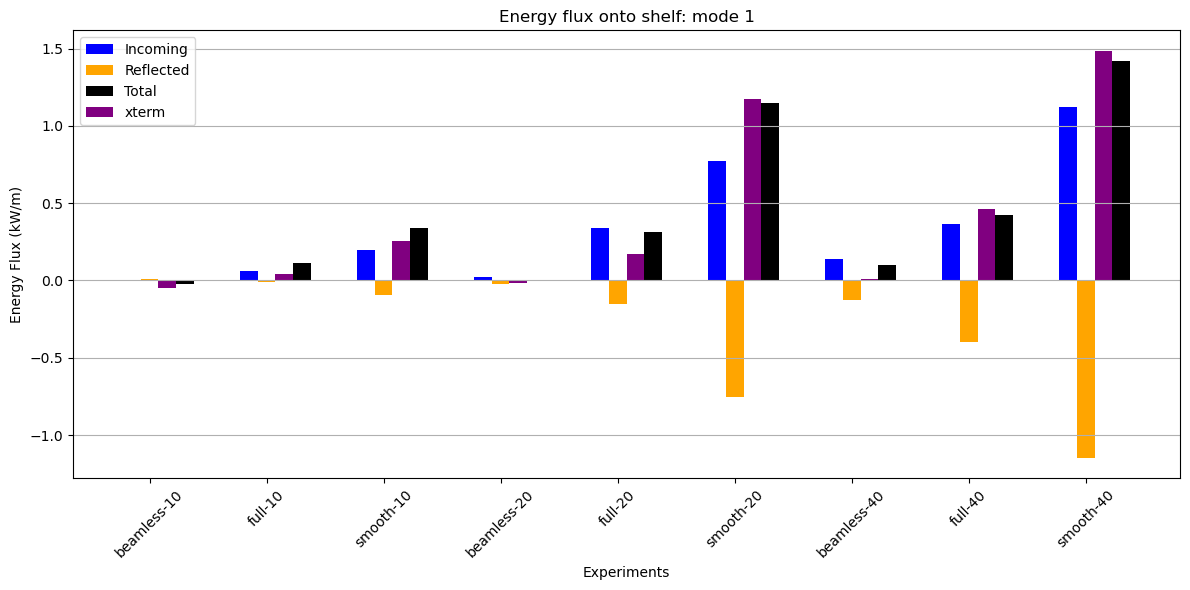

[ 0.00049825 -0.00052216 -0.00093561  0.00302155 -0.00278618  0.00318166
  0.00357513 -0.00429664 -0.00849788]


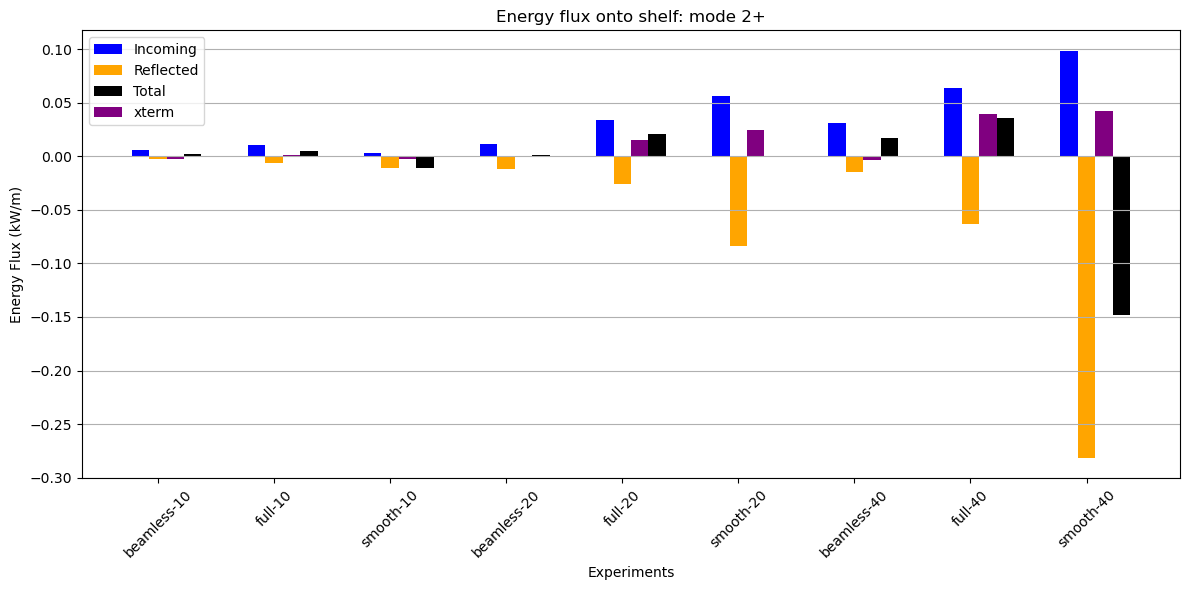

[ 0.00916406  0.01434773 -0.02230304  0.01856916 -0.05026126 -0.04543348
  0.07751935 -0.01258813 -0.0506972 ]


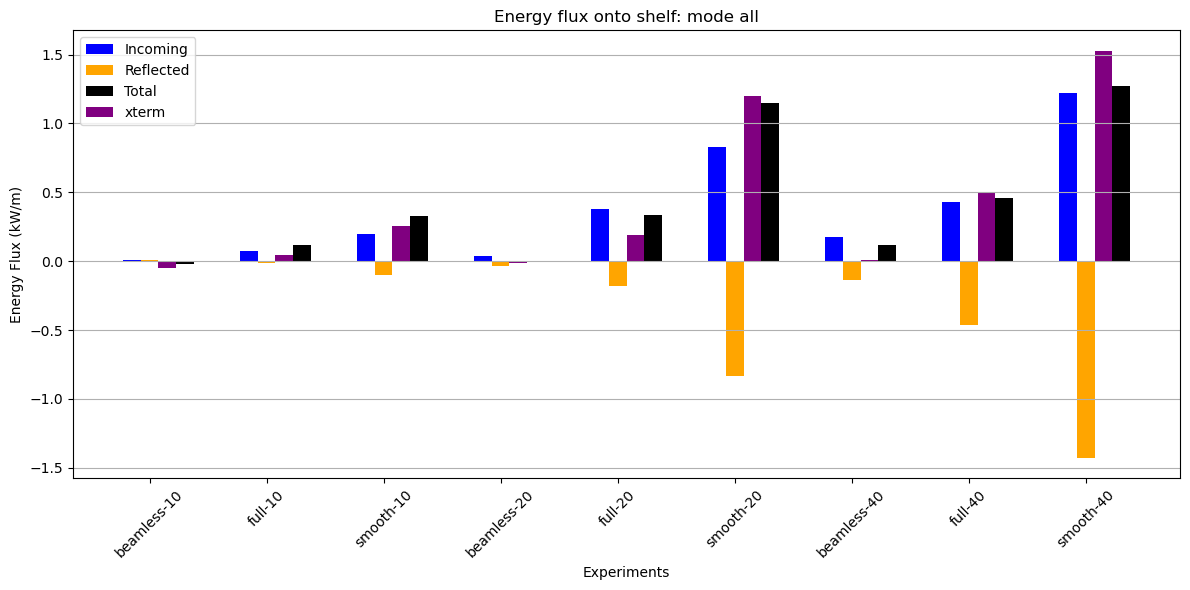

In [34]:
import numpy as np

import matplotlib.pyplot as plt

def plot_EF_bars(modes = 0):

    experiments = ["beamless-10", "full-10","smooth-10", "beamless-20", "full-20","smooth-20","beamless-40", "full-40","smooth-40"]

    # Initialize data containers
    total = []
    forward = []
    backward = []
    xterm = []
    # Collect data for each experiment
    for expt in experiments:
        forward.append(mean_EF_in_box(data[expt].EF_alongbeam_forward, data[expt].EF_acrossbeam_forward).isel(mode=modes).sum("mode").values)
        backward.append(mean_EF_in_box(data[expt].EF_alongbeam_backward, data[expt].EF_acrossbeam_backward).isel(mode=modes).sum("mode").values)
        total.append(mean_EF_in_box(data[expt].EF_alongbeam, data[expt].EF_acrossbeam).isel(mode=modes).sum("mode").values)
        xterm.append(mean_EF_in_box(data[expt].EF_alongbeam_xterm, data[expt].EF_acrossbeam_xterm).isel(mode=modes).sum("mode").values)

    forward,backward,total,xterm = np.array(forward), np.array(backward), np.array(total), np.array(xterm)
    print(total - forward - backward - xterm)

    # Create bar plots with grouped bars for each experiment
    x = np.arange(len(experiments))  # X-axis positions
    width = 0.15  # Bar width for each group

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot Mode 1
    ax.bar(x - width, forward, color='blue', width=width, label='Incoming')

    # Plot Mode 2+
    ax.bar(x, backward, color='orange', width=width, label='Reflected')

    # Plot Total
    ax.bar(x + 2 * width, total, color='black', width=width, label='Total')
    
    # Plot xterm
    ax.bar(x + width, xterm, color='purple', width=width, label='xterm')
    # Set x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(experiments, rotation=45)
    ax.set_xlabel("Experiments")
    modestr = 1
    if modes == [0]:
        modestr = 1
    elif modes.start == 1 and modes.stop == None:
        modestr = "2+"
    elif modes.start == None and modes.stop == None:
        modestr = "all"

    # Add labels and legend
    ax.set_ylabel("Energy Flux (kW/m)")
    ax.set_title(f"Energy flux onto shelf: mode {modestr}")
    ax.legend()

    # Add grid
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()


plot_EF_bars(modes = [0])
plot_EF_bars(modes = slice(1,None))
plot_EF_bars(modes = slice(None,None))


## Plot contours over the cross terms

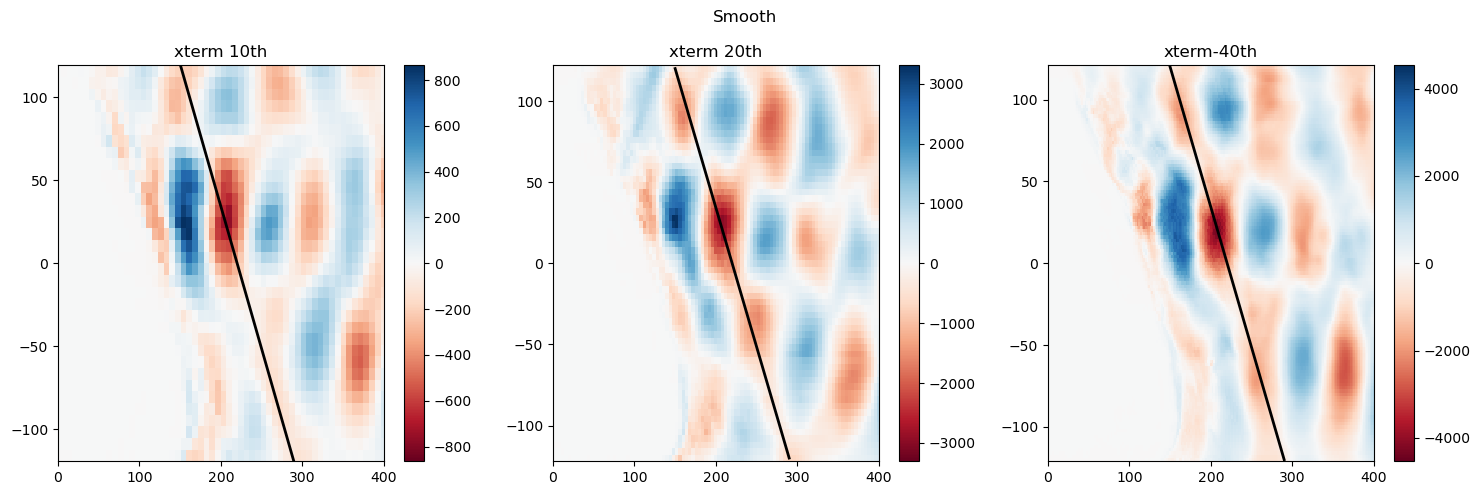

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

total = (data["smooth-10"].EF_alongbeam_xterm * np.sin(theta) + np.cos(theta) *  data["smooth-10"].EF_acrossbeam_xterm).sum("mode")
total.plot(ax=ax[0], add_labels=False,cmap = "RdBu")
ax[0].set_title("xterm 10th")
ax[0].set_xlabel("")
ax[0].set_ylabel("")
ax[0].set_xlim(0, 400)

total = (data["smooth-20"].EF_alongbeam_xterm * np.sin(theta) + np.cos(theta) *  data["smooth-20"].EF_acrossbeam_xterm).sum("mode")
total.plot(ax=ax[1], add_labels=False,cmap = "RdBu")
ax[1].set_title("")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("xterm 20th")
ax[1].set_xlim(0, 400)

total = (data["smooth-40"].EF_alongbeam_xterm * np.sin(theta) + np.cos(theta) *  data["smooth-40"].EF_acrossbeam_xterm).sum("mode")
total.plot(ax=ax[2], add_labels=False,cmap = "RdBu")
ax[2].set_title("")
ax[2].set_xlabel("")
ax[2].set_ylabel("")
ax[2].set_title("xterm-40th")
ax[2].set_xlim(0, 400)

x_adjust = 0

for a in ax.flatten():
    a.plot([x0 + x_adjust,x1 + x_adjust],[y0,y1],color = "black",linewidth = 2)
fig.suptitle("Smooth")
plt.tight_layout()



In [ ]:
xmax = 400
expt = "smooth-10"
fig,ax = plt.subplots(3,2,figsize=(20,20))

for a in ax.flatten():
    data[expt].sel(xb = slice(0,xmax)).bathy.plot(vmax = 0, vmin = -4000, cmap = cmocean.cm.deep_r,ax = a,add_colorbar = False)
    data[expt].sel(xb=slice(0, xmax)).bathy.plot.contour(levels=[-1000,-2000,-3000],ax = a)


scale = 10000
plot_KE_quiver(data[expt].EF_alongbeam_forward,data[expt].EF_acrossbeam_forward,ax[0,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(data[expt].EF_alongbeam_forward,data[expt].EF_acrossbeam_forward,ax[0,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
plot_KE_quiver(data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward,ax[1,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward,ax[1,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
plot_KE_quiver(data[expt].EF_alongbeam,data[expt].EF_crossbeam,ax[2,0],mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_quiver(data[expt].EF_alongbeam,data[expt].EF_crossbeam,ax[2,1],mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
for a in ax.flatten():
    a.plot([east_x0,east_x1],[east_y0,east_y1],color = "white",linewidth = 2)
    a.plot([north_x0,north_x1],[north_y,north_y],color = "white",linewidth = 2)
    a.plot([south_x0,south_x1],[south_y,south_y],color = "white",linewidth = 2)
    a.set_aspect('equal')
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_title("")
    a.set_xlim(0,xmax)

ax[0,0].set_title("mode 1")
ax[0,1].set_title("modes 2+")
ax[0,0].set_ylabel("Forward filtered")
ax[1,0].set_ylabel("Backward filtered")
ax[2,0].set_ylabel("Total")
fig.suptitle(expt)
fig.savefig(f"/g/data/nm03/ab8992/dropbox/EnergyFluxShelf/{expt}.png")

: 

## Test out generic contour integral to do the energy flux comparisons

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


Experiment          1 IN       2+ IN       1 OUT      2+ OUT     2+/1 IN    2+/1 OUT      IN/OUT
full-10            126.9         6.6        27.0         3.9         5.2        14.4        23.1
full-20            262.0        19.6       111.5        10.9         7.5         9.8        43.5
full-40            376.6        33.2       265.6        25.1         8.8         9.4        70.9


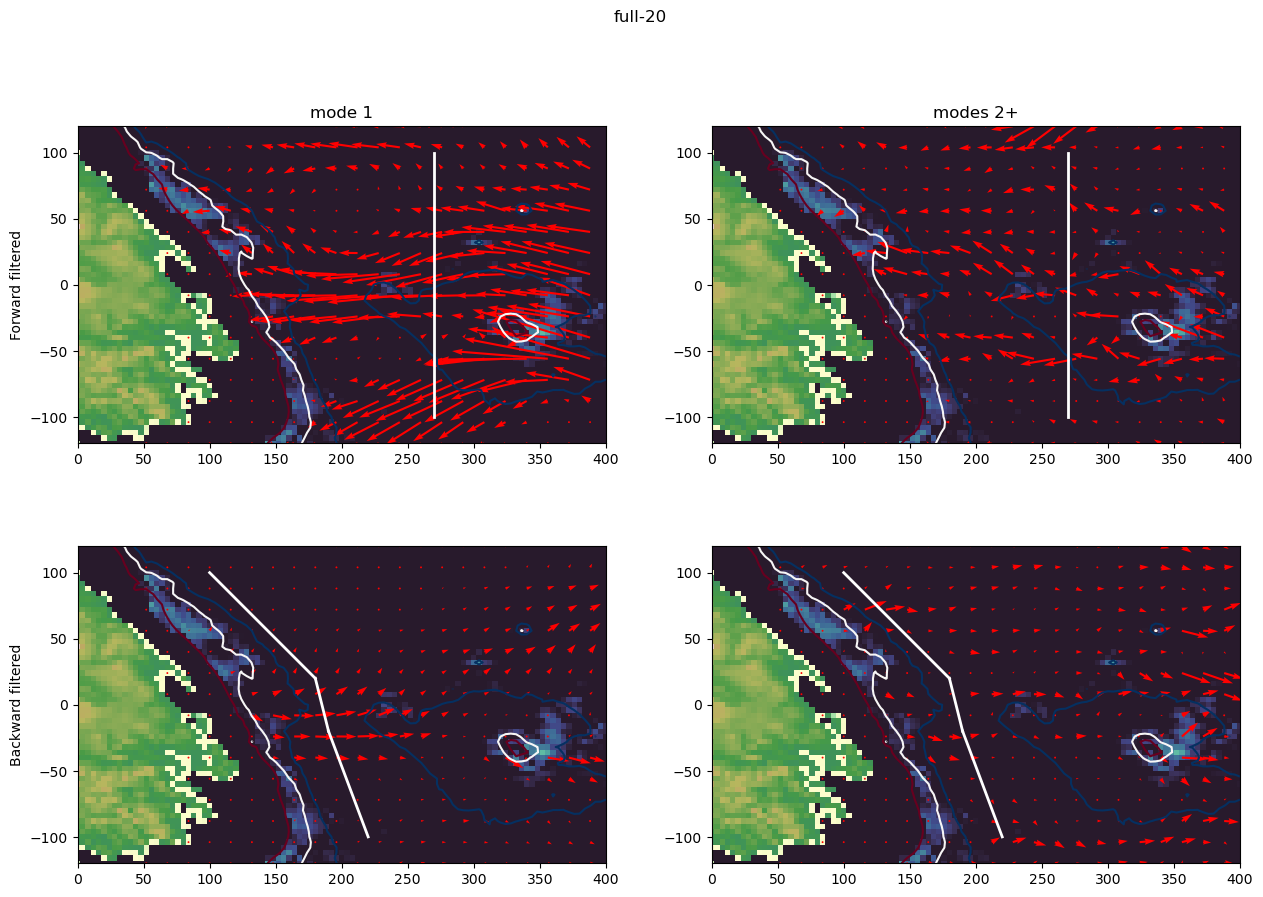

In [39]:


def plot_KE_dissipation_quiver(data,ax,orientation = "",mode = 0,xlim = slice(50,250),ylim = slice(-80,80),scale = 3000):
    if orientation != "":
        orientation = "_" + orientation
    alongbeam = data[f"EF_alongbeam{orientation}"].sel(xb = xlim,yb = ylim).isel(mode = mode)
    acrossbeam = data[f"EF_acrossbeam{orientation}"].sel(xb = xlim,yb = ylim).isel(mode = mode)

    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")

    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    yspacing = 2
    xspacing = 2
    if "20" in expt:
        yspacing,xspacing = yspacing * 2, xspacing * 2
    elif "40" in expt:
        yspacing,xspacing = yspacing * 4, xspacing * 4
    _yb = acrossbeam.yb[::yspacing]
    _xb = acrossbeam.xb[::xspacing]
    _along = (alongbeam )[::yspacing,::xspacing]
    _across = (acrossbeam)[::yspacing,::xspacing]

    # print(magnitude)
    np.log(data.filtered_dissipation).plot(ax=ax, add_colorbar=False, cmap=cmocean.cm.deep_r,vmin = -4,vmax = -1)
    ax.quiver(_xb, _yb, _along, _across, color="red", scale=scale,scale_units = "width",width = 0.004)
    
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    ax.set_ylim(-120,120)
    ax.set_xlim(0,1200)
    ax.set_xlabel("")
    ax.set_ylabel("")

xmax = 400
expt = "full-20"
fig,ax = plt.subplots(2,2,figsize=(15,10))
for a in ax.flatten():
    data[expt].sel(xb = slice(0,xmax)).bathy.plot(vmax = 0, vmin = -4000, cmap = cmocean.cm.deep_r,ax = a,add_colorbar = False)
    data[expt].sel(xb=slice(0, xmax)).bathy.plot.contour(levels=[-1000,-2000,-3000],ax = a)
scale = 20000
plot_KE_dissipation_quiver(data[expt],ax[0,0],orientation = "forward",mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_dissipation_quiver(data[expt],ax[0,1],orientation = "forward",mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)
plot_KE_dissipation_quiver(data[expt],ax[1,0],orientation = "backward",mode = 0,xlim = slice(50,xmax),ylim = slice(None,None),scale = scale)
plot_KE_dissipation_quiver(data[expt],ax[1,1],orientation = "backward",mode = slice(1,None),xlim = slice(50,xmax),ylim = slice(None,None),scale = scale / 5)

## Select the contour integrals and plot

xs_incoming, ys_incoming = [270, 270], [-100, 100]
xs_reflect1, ys_reflect1 = [100, 180], [100, 20]
xs_reflect2, ys_reflect2 = [180, 190], [20, -20]
xs_reflect3, ys_reflect3 = [190, 220], [-20, -100]

ax[0,0].plot(xs_incoming,ys_incoming,color = "white",linewidth = 2)
ax[0,1].plot(xs_incoming,ys_incoming,color = "white",linewidth = 2)
ax[1,0].plot(xs_reflect1,ys_reflect1,color = "white",linewidth = 2)
ax[1,1].plot(xs_reflect1,ys_reflect1,color = "white",linewidth = 2)
ax[1,0].plot(xs_reflect2,ys_reflect2,color = "white",linewidth = 2)
ax[1,1].plot(xs_reflect2,ys_reflect2,color = "white",linewidth = 2)
ax[1,0].plot(xs_reflect3,ys_reflect3,color = "white",linewidth = 2)
ax[1,1].plot(xs_reflect3,ys_reflect3,color = "white",linewidth = 2)

for a in ax.flatten():
    a.set_aspect('equal')
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_title("")
    a.set_xlim(0,xmax)

ax[0,0].set_title("mode 1")
ax[0,1].set_title("modes 2+")
ax[0,0].set_ylabel("Forward filtered")
ax[1,0].set_ylabel("Backward filtered")
fig.suptitle(expt)
print(f"{'Experiment':<12}{'1 IN':>12}{'2+ IN':>12}{'1 OUT':>12}{'2+ OUT':>12}{'2+/1 IN':>12}{'2+/1 OUT':>12}{'IN/OUT':>12}")

for expt in ["full-10","full-20","full-40"]:
    # incoming = generic_contour_integral(xs_incoming,ys_incoming,-1 * data[expt].EF_alongbeam_forward,-1 * data[expt].EF_acrossbeam_forward)["energy"]
    incoming1 = generic_contour_integral(xs_reflect1,ys_reflect1,-1 * data[expt].EF_alongbeam_forward,-1 * data[expt].EF_acrossbeam_forward)
    incoming2 = generic_contour_integral(xs_reflect2,ys_reflect2,-1 * data[expt].EF_alongbeam_forward,-1 * data[expt].EF_acrossbeam_forward)
    incoming3 = generic_contour_integral(xs_reflect3,ys_reflect3,-1 * data[expt].EF_alongbeam_forward,-1 * data[expt].EF_acrossbeam_forward)

    reflect1 = generic_contour_integral(xs_reflect1,ys_reflect1,data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward)
    reflect2 = generic_contour_integral(xs_reflect2,ys_reflect2,data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward)
    reflect3 = generic_contour_integral(xs_reflect3,ys_reflect3,data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward)


    reflect = reflect1["energy"] + reflect2["energy"] + reflect3["energy"]
    incoming = incoming1["energy"] + incoming2["energy"] + incoming3["energy"]

    in_ratio = (incoming.isel(mode=slice(1, None)).sum('mode').values / incoming.isel(mode = 0).values) * 100
    out_ratio = (reflect.isel(mode=slice(1, None)).sum('mode').values / reflect.isel(mode=0).values) * 100
    in_out = (reflect.sum('mode').values / incoming.sum('mode').values) * 100
    print(f"{expt:<12}{incoming.isel(mode=0).values:>12.1f}{incoming.isel(mode=slice(1, None)).sum('mode').values:>12.1f}{reflect.isel(mode=0).values:>12.1f}{reflect.isel(mode=slice(1, None)).sum('mode').values:>12.1f}{in_ratio:>12.1f}{out_ratio:>12.1f}{in_out:>12.1f}")


-20.0 190.0
-16.0 187.0
-8.0 181.0
0.0 175.0
8.0 169.0
16.0 163.0
24.0 157.0
32.0 151.0
40.0 145.0
48.0 139.0
56.0 133.0
64.0 126.99999999999999
72.0 120.99999999999999
80.0 114.99999999999999
88.0 108.99999999999999
96.0 102.99999999999999
-100.0 220.0
-98.0 219.25
-96.0 218.5
-92.0 217.0
-88.0 215.5
-86.0 214.75
-82.0 213.25
-80.0 212.5
-76.0 211.0
-72.0 209.5
-70.0 208.75
-66.0 207.25
-64.0 206.5
-60.0 205.0
-56.0 203.5
-54.0 202.75
-50.0 201.25
-48.0 200.5
-44.0 199.0
-40.0 197.5
-38.0 196.75
-34.0 195.25
-32.0 194.5
-28.0 193.0
-24.0 191.5
-22.0 190.75


Text(0.5, 0, '')

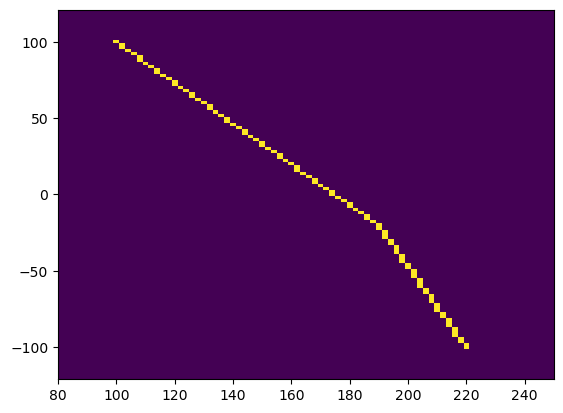

In [7]:
def generic_contour_mask(xs,ys,data):
    dx = (data.yb[1] - data.yb[0]).values

    if xs[0] == xs[1]:
        return xr.where(
            (np.abs(data.xb - xs[0]) < dx) *
            (np.abs(data.yb) <= ymax)
            ,1,0
        ).fillna(0)
    m = (ys[1] - ys[0]) / (xs[1] - xs[0]) #! FIX TO HANDLE VERTICAL LINE
    c = ys[0] - m * xs[0]
    return xr.where(
        (np.abs(data.yb - m * data.xb - c) < dx) *
          (data.yb <= ys[0]) *
          (data.yb >= ys[1])
          ,1,0
        ).fillna(0)

def manual_contour_mask(xs,ys,data):
    dx = (data.yb[1] - data.yb[0]).values
    if xs[0] == xs[1]: # HANDLE VERTICAL LINE
        return xr.where(
            (np.abs(data.xb - xs[0]) < dx) *
            (np.abs(data.yb) <= ymax)
            ,1,0
        ).fillna(0)
    m = (ys[1] - ys[0]) / (xs[1] - xs[0]) #! FIX TO HANDLE VERTICAL LINE
    c = ys[0] - m * xs[0]
    x_points = np.arange(xs[0],xs[1],dx)
    y_points = m * x_points + c
    # y_points = np.round(y_points,1)
    x_points = np.round(x_points,0)


    mask = xr.where(
        (np.abs(data.xb - x_points[0]- 1e-5)  <= dx/2) *
        (np.abs(data.yb - y_points[0]- 1e-5)  <= dx/2)
        ,1,0
        )
    for i in range(1,len(x_points)):
        mask += xr.where(
            (np.abs(data.xb - x_points[i] - 1e-5)  <= dx/2) *
            (np.abs(data.yb - y_points[i] - 1e-5)  <= dx/2)
            ,1,0
            )
    gaps = xr.where(mask.sel(yb = slice(min(ys),max(ys))).sum("xb") != 1,0,1)
    for i in range(len(gaps.yb.values)):
        if gaps[i] == 0:
            print(gaps[i].yb.values,(gaps[i].yb.values - c) / m)
            mask += xr.where(
                (np.abs(data.yb - gaps[i].yb) < dx/20) *
                (np.abs((gaps[i].yb - c) / m - data.xb - 1e-5) < dx/2 )
                ,1,0
            )
    gaps = xr.where(mask.sel(yb = slice(min(ys),max(ys))).sum("xb") != 1,0,1)
    return mask

xs_incoming, ys_incoming = [[270, 270]], [[-100, 100]]
xs_reflect, ys_reflect = [[100, 190],[190, 220]], [[100, -20],[-20, -100]]
ymax = 100

xs,ys = xs_reflect,ys_reflect
alongbeam = data[expt].EF_alongbeam_forward
mask = alongbeam.fillna(0) * 0
length = 0
for i in range(len(xs)):
    mask += manual_contour_mask(xs[i],ys[i],alongbeam)
    length += np.sqrt((xs[i][1] - xs[i][0])**2 + (ys[i][1] - ys[i][0])**2) * 1000

mask = xr.where(mask == 0,0,1)
mask.isel(mode = 0).plot(add_colorbar = False)

# plt.plot(xs[0],ys[0],color = "black",linewidth = 2)
# plt.plot(xs[1],ys[1],color = "black",linewidth = 2)
plt.xlim(80,250)
# plt.ylim(-40,80)
plt.title("")
plt.ylabel("")
plt.xlabel("")

## New idea May 1st: Just look at the 'remote' EF component

In [ ]:
def generic_contour_mask(xs,ys,data):
    dx = (data.xb[1] - data.xb[0]).values

    if xs[0] == xs[1]:
        return xr.where(
            (np.abs(data.xb - xs[0]) < dx) *
            (np.abs(data.yb) <= ymax)
            ,1,0
        ).fillna(0)
    m = (ys[1] - ys[0]) / (xs[1] - xs[0]) #! FIX TO HANDLE VERTICAL LINE
    c = ys[0] - m * xs[0]
    return xr.where(
        (np.abs(data.yb - m * data.xb - c) < dx) *
          (np.abs(data.yb) <= ymax)
          ,1,0
        ).fillna(0)

def generic_contour_integral(xs,ys,alongbeam,acrossbeam):
    """
    Pass x and y coords of straight line. Need to pre-multiply data to get orientation to line 
    correct as function just integrates along the line. If line is parallel to an axis, just 
    pre multiply alongbeam or acrossbeam by 0 to ensure that we don't integrate over empty dimension.
    """
    length = 0
    if type(xs[0]) == list:
        mask = alongbeam.fillna(0) * 0
        for i in range(len(xs)):
            mask += generic_contour_mask(xs[i],ys[i],alongbeam)
            length += np.sqrt((xs[i][1] - xs[i][0])**2 + (ys[i][1] - ys[i][0])**2) * 1000
    else:
        mask = generic_contour_mask(xs,ys,alongbeam)
        length = np.sqrt((xs[1] - xs[0])**2 + (ys[1] - ys[0])**2) * 1000

    out = (mask * alongbeam).sum("xb").integrate("yb")
    out += (mask * acrossbeam).sum("yb").integrate("xb")
    out = {"energy":out / 1000,"length":length * 1000}
    return out # Convert km -> m


xs_incoming, ys_incoming = [270, 270], [-100, 100]
xs_reflect, ys_reflect = [[100 + 20, 190],[190 + 20, 220]], [[100, -20],[-20, -100]]


cdata = {} # Contour integral data

for expt in expts:
    # incoming = generic_contour_integral(xs_incoming,ys_incoming,-1 * data[expt].EF_alongbeam_forward,-1 * data[expt].EF_acrossbeam_forward)["energy"]
    incoming = generic_contour_integral(xs_reflect,ys_reflect,-1 * data[expt].EF_alongbeam_forward,-1 * data[expt].EF_acrossbeam_forward)

    reflect = generic_contour_integral(xs_reflect,ys_reflect,data[expt].EF_alongbeam_backward,data[expt].EF_acrossbeam_backward)

    cdata[expt] = xr.merge(
        [
            incoming["energy"].rename("incoming"),
            reflect["energy"].rename("outgoing"),
            xr.DataArray(incoming["length"]).rename("length"),
        ]
    )

cdata["remote-10"] = cdata["full-10"] - cdata["beamless-10"]
cdata["remote-20"] = cdata["full-20"] - cdata["beamless-20"]
cdata["remote-40"] = cdata["full-40"] - cdata["beamless-40"]

In [36]:

print(f"{'Experiment':<12}{'1 IN':>12}{'2+ IN':>12}{'1 OUT':>12}{'2+ OUT':>12}{'2+/1 IN':>12}{'2+/1 OUT':>12}{'IN/OUT':>12}")

for expt in ["remote-10","remote-20","remote-40","full-10","full-20","full-40","beamless-10","beamless-20","beamless-40"]:
    in_ratio = (cdata[expt].incoming.isel(mode=slice(1, None)).sum('mode').values / cdata[expt].incoming.isel(mode = 0).values) * 100
    out_ratio = (cdata[expt].outgoing.isel(mode=slice(1, None)).sum('mode').values / cdata[expt].outgoing.isel(mode=0).values) * 100
    in_out = (cdata[expt].outgoing.sum('mode').values / cdata[expt].incoming.sum('mode').values) * 100
    print(f"{expt:<12}{cdata[expt].incoming.isel(mode=0).values:>12.1f}{cdata[expt].incoming.isel(mode=slice(1, None)).sum('mode').values:>12.1f}{cdata[expt].outgoing.isel(mode=0).values:>12.1f}{cdata[expt].outgoing.isel(mode=slice(1, None)).sum('mode').values:>12.1f}{in_ratio:>12.1f}{out_ratio:>12.1f}{in_out:>12.1f}")


Experiment          1 IN       2+ IN       1 OUT      2+ OUT     2+/1 IN    2+/1 OUT      IN/OUT
remote-10           63.8        -1.4        -1.0         1.6        -2.1      -160.9         0.9
remote-20          265.3        12.9        90.3         9.6         4.8        10.6        35.9
remote-40          386.0        13.1       222.8        26.5         3.4        11.9        62.5
full-10             93.3         3.8        19.9         3.4         4.0        17.2        24.0
full-20            295.3        24.4       145.1        14.9         8.3        10.3        50.1
full-40            496.6        40.5       349.4        37.3         8.1        10.7        72.0
beamless-10         29.5         5.1        20.9         1.9        17.3         9.0        65.6
beamless-20         30.0        11.6        54.9         5.3        38.6         9.7       144.9
beamless-40        110.6        27.4       126.5        10.8        24.7         8.5        99.5
